In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

#define  basis functions
def make_basis(x):
    # the components are 1,x, cos(2 \pi x), sin(2 \pi x)...
    periodic = np.hstack([np.cos(2*np.pi*x),np.sin(2*np.pi*x),np.cos(4*np.pi*x),np.sin(4*np.pi*x),np.cos(6*np.pi*x),np.sin(6*np.pi*x),np.cos(8*np.pi*x),np.sin(8*np.pi*x),np.cos(10*np.pi*x),np.sin(10*np.pi*x),np.cos(12*np.pi*x),np.sin(12*np.pi*x)])
    return np.hstack([np.ones((x.shape[0],1)),x, periodic ]) 

#  periodic basis starts at column:
col_per = 2

#baseline model
def run_model(x,y,plot=False):    
    H = make_basis(x.reshape(-1,1))
    
    #select non periodic components of the basis
    H_np = H[:,0:col_per]

    with pm.Model() as model:
        #prior
        w = pm.Normal('weights', mu=0, sd=50, shape=(H.shape[1],))
        sigma = pm.HalfCauchy('sigma', 5)

        #linear model
        mu = pm.Deterministic('mu', pm.math.matrix_dot(H,w).T)

        #likelihood
        y_obs = pm.Normal('y', mu=mu, sd=sigma, observed=y)

        #we can do  an approximated inference
    with model:
        inference = pm.ADVI()
        approx = pm.fit(60000, method=inference)
        
    posterior = approx.sample(draws=500)
    
    if max(np.mean(posterior['weights'],axis=0)[2:]) > max(np.mean(posterior['weights'],axis=0)[0:2]):
        prediction = np.dot(H_np,posterior['weights'][:,0:col_per].T).T
    else:
        prediction = np.dot(H,posterior['weights'].T).T
    

    Gradients = []
    for i in range(prediction.shape[0]):
        Gradients.append(np.min(np.gradient(prediction[i,:], x)))

        
    posterior_probability_deriviative_is_positive = len(np.where(np.array(Gradients)>0)[0])/len(Gradients)
    print("probability that the function is increasing=", posterior_probability_deriviative_is_positive)
    if posterior_probability_deriviative_is_positive>0.95:
        return 1
    else:
        return 0

    
#this is the inpu
x = np.linspace(0,1,100)    

In [2]:
make_basis(x.reshape(-1,1))

array([[ 1.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  1.01010101e-02,  9.97986676e-01, ...,
         3.12033446e-01,  9.28367933e-01,  3.71662456e-01],
       [ 1.00000000e+00,  2.02020202e-02,  9.91954813e-01, ...,
         5.92907929e-01,  7.23734038e-01,  6.90079011e-01],
       ...,
       [ 1.00000000e+00,  9.79797980e-01,  9.91954813e-01, ...,
        -5.92907929e-01,  7.23734038e-01, -6.90079011e-01],
       [ 1.00000000e+00,  9.89898990e-01,  9.97986676e-01, ...,
        -3.12033446e-01,  9.28367933e-01, -3.71662456e-01],
       [ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
        -1.22464680e-15,  1.00000000e+00, -1.46957616e-15]])

In [3]:
np.ones((x.shape[0],1))

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

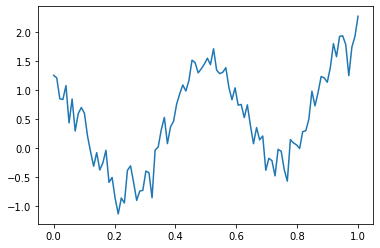

In [4]:
y =  x + np.cos(4*np.pi*x) + np.random.randn(len(x))*0.2
plt.plot(x,y)

In [5]:
run_model(x,y,plot=True)

Average Loss = 91.867: 100%|██████████| 60000/60000 [00:19<00:00, 3128.66it/s]
Finished [100%]: Average Loss = 91.866


probability that the function is increasing= 1.0


1

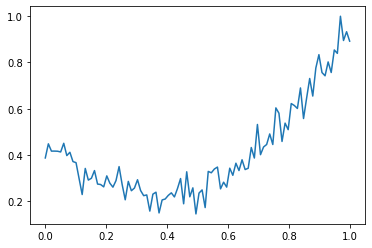

In [6]:
#toy example
y =  x/2-2*np.exp(-(x-0.5)**2) + 2 + np.random.randn(len(x))*0.05
plt.plot(x,y)

In [7]:
run_model(x,y, plot=True)

Average Loss = -38.616: 100%|██████████| 60000/60000 [00:15<00:00, 3767.02it/s] 
Finished [100%]: Average Loss = -38.61


probability that the function is increasing= 0.0


0

In [8]:
x = np.linspace(0,1,100)
train_df = pd.read_csv("./data/train.csv")
rows = train_df.shape[0] - 70
actual = train_df.head(rows)['Category']

print(train_df.shape)
print(rows)
print(actual.shape[0])

(75, 102)
5
5


In [ ]:

predicted = []
for r in range(rows):
    print(f'Iteration: {r} of {rows}')
    id_row = train_df.iloc[r,0]
    y = train_df.iloc[r,0:100].values[:,None]
    decision = run_model(x,y)
    predicted.append(decision)

Iteration: 0 of 5


Average Loss = 39,114:  25%|██▍       | 14818/60000 [00:05<00:16, 2707.78it/s]  

In [ ]:
print(predicted)

from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

results = confusion_matrix(actual, predicted) 
print(results)
print('Accuracy Score :', accuracy_score(actual, predicted))
print ('The Report : ')
print (classification_report(actual, predicted))

In [ ]:
# x = np.linspace(0,1,100)
# test_df = pd.read_csv("./data/test.csv")


# Decision = pd.DataFrame(columns=['Id','Category'])
# for r in range(test_df.shape[0]):
#     id_row = test_df.iloc[r,0]
#     y = test_df.iloc[r,1:].values
#     decision = run_model(x,y)
#     Decision = Decision.append({'Id': int(id_row), 'Category': int(decision)}, ignore_index=True) 
#     print(Decision)
# #     Decision.to_csv("Decision_baseline.csv",  index=False)

In [ ]:
# x = np.linspace(0,1,100)
# test_df = pd.read_csv("./data/test.csv")
# test_df.head()

In [ ]:
# test_df.iloc[0,1:].values